In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns

import IPython.display as ipd

# Data preprocessing

For data preprocessing with FMA metadata, see [THIS](https://www.kaggle.com/code/jojothepizza/genre-classification-with-fma-data). As the result, I got dataframe with genre labels and musical features. Due to computational costs, I will use saved csv file in this notebook.

In [6]:
data = pd.read_csv('data/data_FMA_genre_clf.csv', index_col=0)

In [7]:
data

,genre_top,chroma_cens_01_kurtosis,chroma_cens_02_kurtosis,chroma_cens_03_kurtosis,chroma_cens_04_kurtosis,chroma_cens_05_kurtosis,chroma_cens_06_kurtosis,chroma_cens_07_kurtosis,chroma_cens_08_kurtosis,chroma_cens_09_kurtosis,...,tonnetz_04_std,tonnetz_05_std,tonnetz_06_std,zcr_01_kurtosis,zcr_01_max,zcr_01_mean,zcr_01_median,zcr_01_min,zcr_01_skew,zcr_01_std
2,Hip-Hop,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,Hip-Hop,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,Hip-Hop,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,Pop,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,Pop,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,Rock,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,...,0.128410,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385
155317,Rock,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059
155318,Rock,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,...,0.108324,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904
155319,Rock,-0.176901,0.187208,-0.050664,0.368843,0.066005,-0.857354,-0.780860,0.626281,-0.630938,...,0.088311,0.018328,0.017936,6.188604,0.167480,0.041480,0.038086,0.004883,1.818740,0.020133


# Feature Engineering

## Manual Selection

This procedure is not ideal for data-driven analysis, but based on my experience with MIR, I will select some feature variables manually. This reduces computational cost and makes it easy to analyze feature importance.

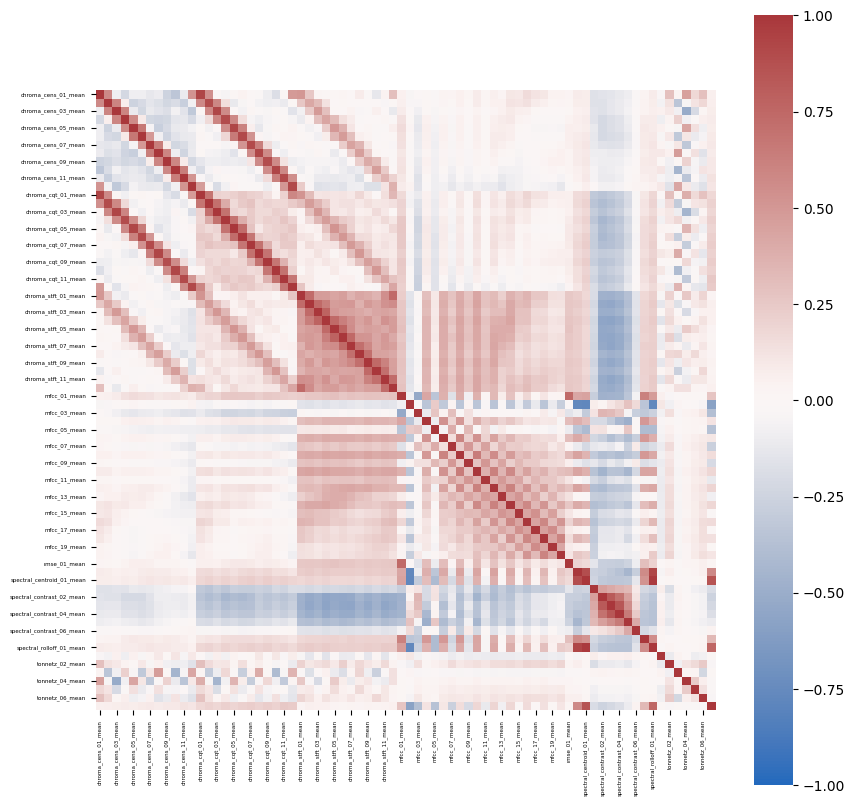

In [8]:
df_ft_mean = data[[col for col in data.columns if 'mean' in col]]

plt.figure(figsize=(10,10))
sns.heatmap(df_ft_mean.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True)
plt.xticks(fontsize = 4)
plt.yticks(fontsize = 4)
plt.show()

- Since chromagram obtained from STFT, CQT, CENS have similar characteristic, I decided to choose only one of them: 'CQT'. You can also see from above that there are diagonal red lines in upper left meaning that chromagram with same pitch class have very high correlation.

- Also for spectral features, I will remove bandwidth and rolloff, because centroids, bandwidth, and rolloff features are very highly correlated. You can see the red points in lower right area.

In [9]:
columns_cens = [col for col in data.columns if 'cens' in col]
columns_cstft = [col for col in data.columns if 'stft' in col]
columns_sband = [col for col in data.columns if 'bandwidth' in col]
columns_srolloff = [col for col in data.columns if 'rolloff' in col]

In [10]:
data_ = data.drop(columns=columns_cens+columns_cstft+columns_sband+columns_srolloff)

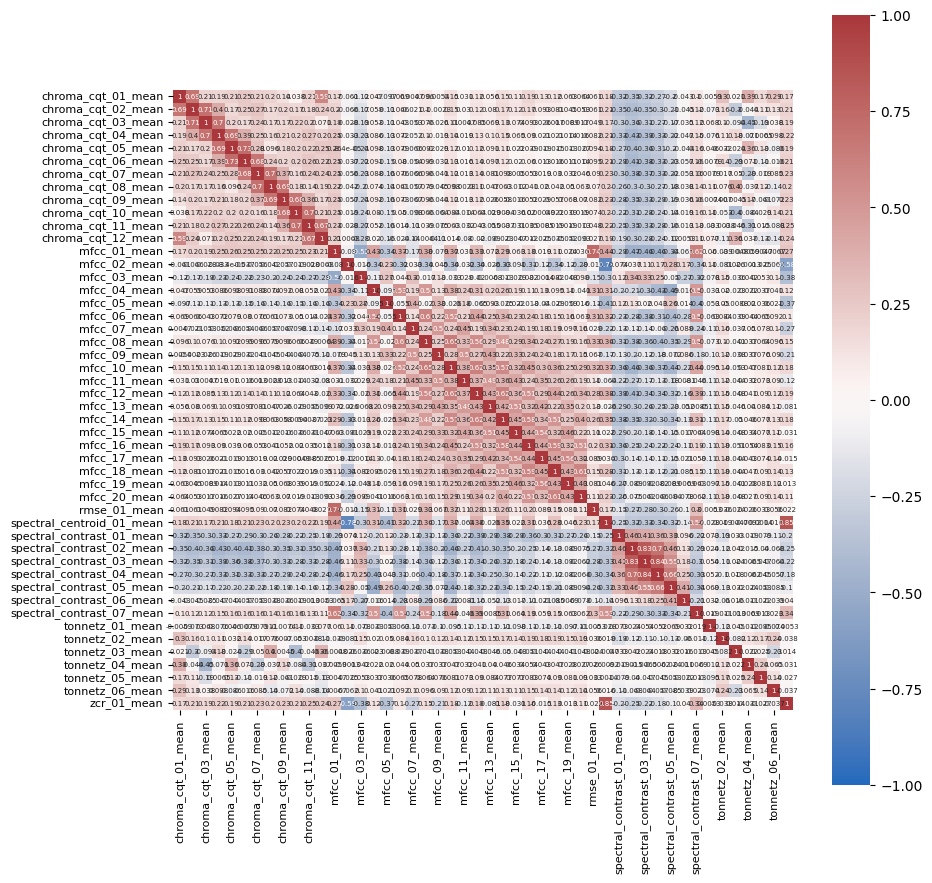

In [11]:
df_ft_mean = data_[[col for col in data_.columns if 'mean' in col]]
plt.figure(figsize=(10,10))
sns.heatmap(df_ft_mean.corr(), cmap='vlag', vmin=-1, vmax=1,center=0, square=True, annot=True, annot_kws={'fontsize':5})
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

## PCA analysis

- with only "mean" features

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis

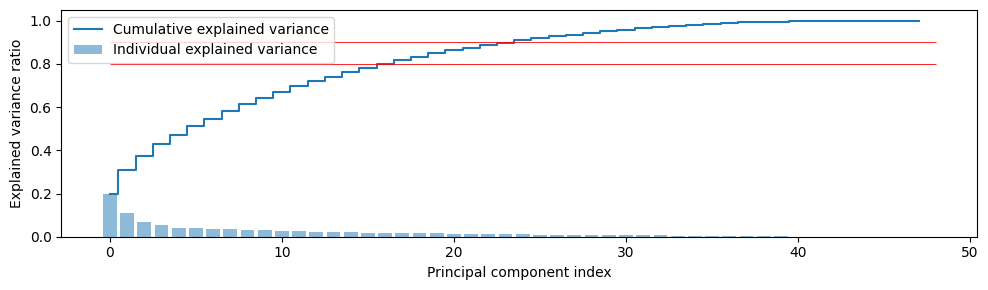

In [13]:
sc = StandardScaler()
df_ft_mean_scaled = sc.fit_transform(df_ft_mean)

pca = PCA()
ft_pca = pca.fit_transform(df_ft_mean_scaled)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.hlines(0.8, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.hlines(0.9, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

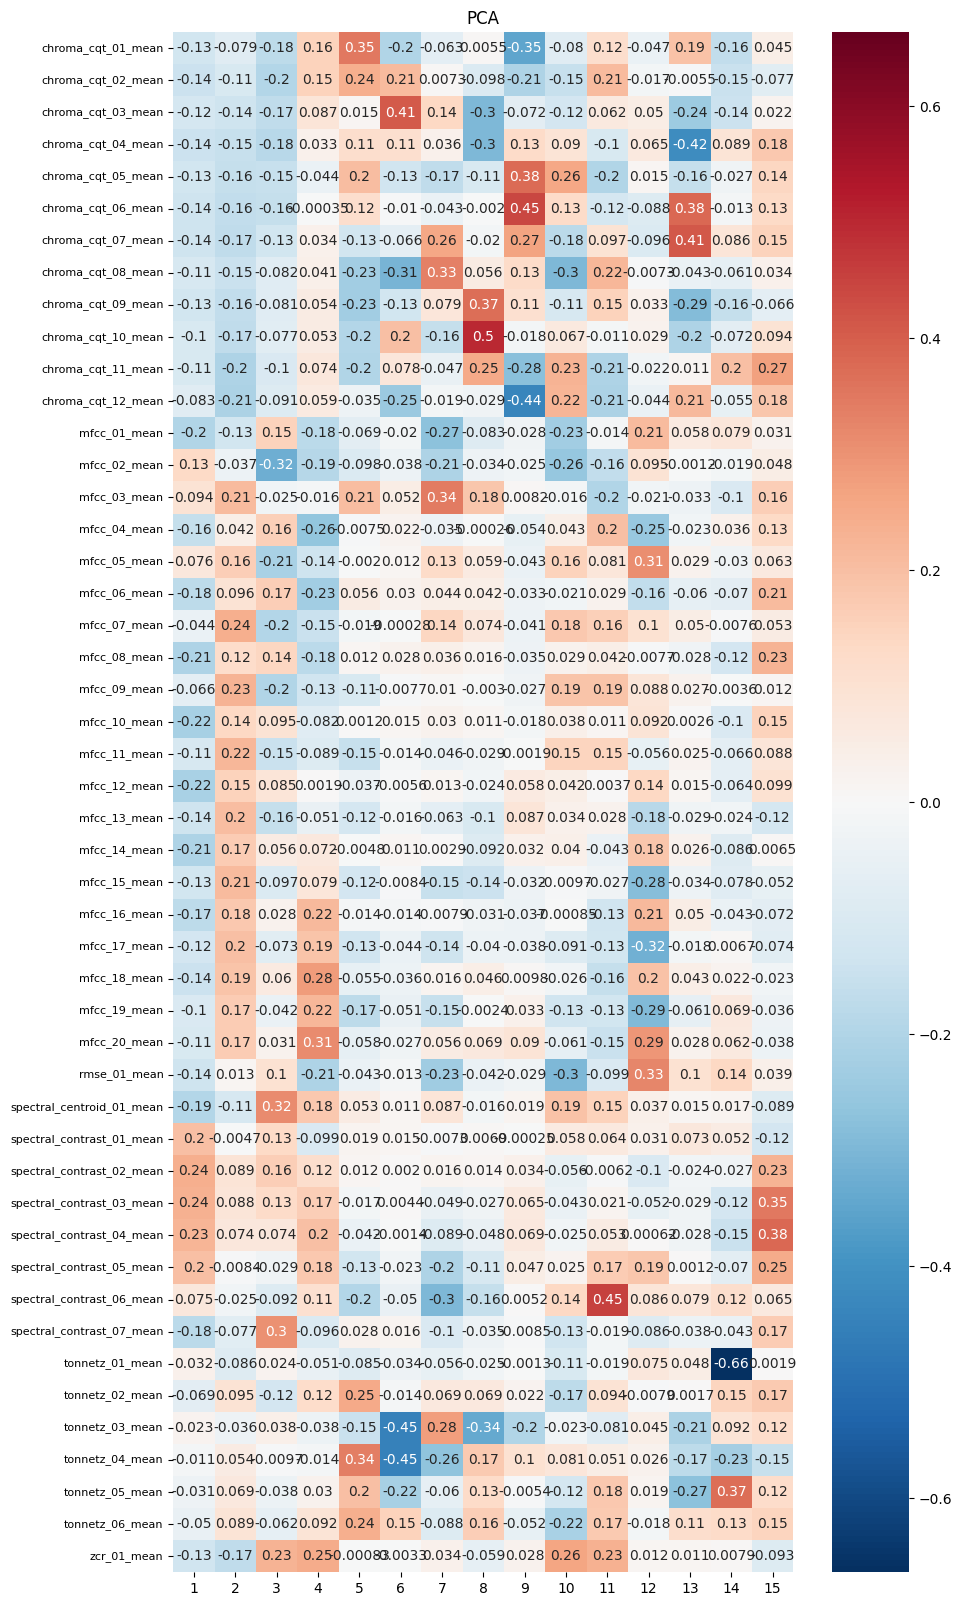

In [14]:
n_comps = 15 # 0.8 explained variance for pca
feature_names = df_ft_mean.columns

methods = [
    ("PCA", PCA())]

for (method, fa) in methods:
    fig, ax = plt.subplots(figsize=(10,20))
    fa.set_params(n_components=n_comps)
    fa.fit(df_ft_mean_scaled)

    components = fa.components_.T

    vmax = np.abs(components).max()
    sns.heatmap(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax, ax=ax, annot=True)
    ax.set_yticklabels(labels=feature_names, rotation=0, fontdict={'fontsize':8})
    ax.set_xticklabels(labels= range(1, n_comps+1))
    ax.set_title(str(method))
    plt.show()

# Classification with ML models

In [15]:
from xgboost import XGBClassifier
#from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, \
ConfusionMatrixDisplay, classification_report

from sklearn.model_selection import train_test_split

## Genre Ambiguity and Label Imbalance

In [16]:
top_genres = data_.genre_top.value_counts()
top_genres

Electronic             25046
Experimental           22724
Rock                   21282
Pop                     8015
Folk                    6083
Hip-Hop                 4534
Instrumental            4367
International           2924
Jazz                    2293
Classical               2102
Blues                   1676
Soul-RnB                 920
Spoken                   768
Country                  726
Old-Time / Historic      710
Easy Listening           173
Name: genre_top, dtype: int64

- Let's remove 'International' genre, because it is not related to musical characteristics.

- Also, genres with less than 1000 songs will be deleted.

In [18]:
international_ids = data_[data_['genre_top']=='International'].index
data_ = data_.drop(index=international_ids)

In [19]:
small_genres = top_genres[top_genres<1000].index
for x in small_genres:
    ids = data_[data_['genre_top']==x].index
    data_ = data_.drop(index=ids)

In [20]:
len(data_)

98122

## Data Split

In [21]:
raw_X = data_.drop(columns=['genre_top'])

labels = data_.loc[:,'genre_top']
cat_y = pd.Categorical(labels)
y = pd.Series(cat_y.codes)

# train / test
raw_X_train, raw_X_test, y_train, y_test = train_test_split(raw_X, y, test_size=0.3, shuffle=True, random_state=123)

### Dimension Reduction

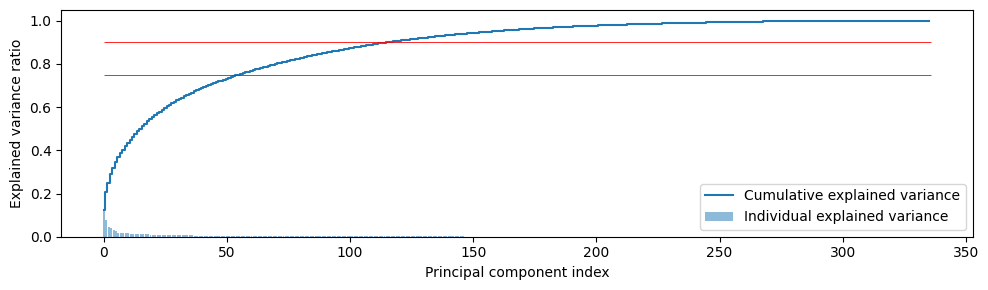

In [60]:
sc = StandardScaler()
raw_X_scaled_train = sc.fit_transform(raw_X_train)
raw_X_scaled_test = sc.transform(raw_X_test)

pca = PCA()
ft_pca = pca.fit_transform(raw_X_scaled_train)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.hlines(0.75, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.hlines(0.9, xmin=0, xmax=len(cum_sum_eigenvalues), color='red', linewidth=.6)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [61]:
n_comps = 50 # 0.75 explained variance for pca
pca = PCA(n_components=n_comps)
X_train = pca.fit_transform(raw_X_scaled_train)
X_train = pd.DataFrame(X_train, index=raw_X_train.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])
X_test = pca.transform(raw_X_scaled_test)
X_test = pd.DataFrame(X_test, index=raw_X_test.index, columns=[f'PCA_{n}' for n in range(1,n_comps+1)])

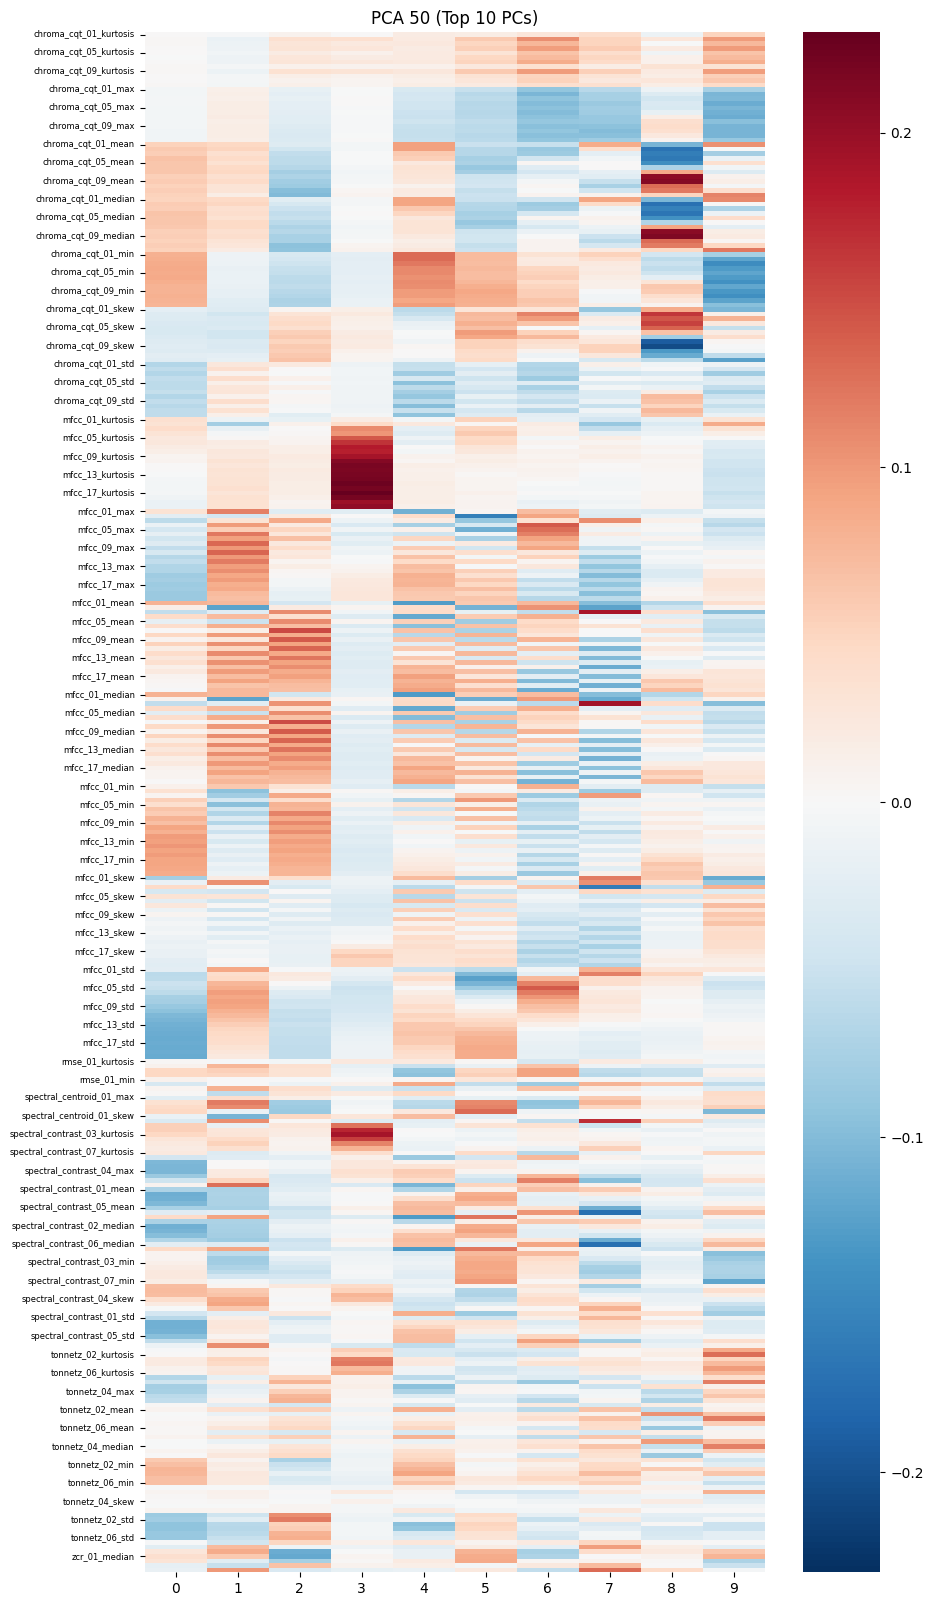

In [74]:
components = pca.components_.T

fig, ax = plt.subplots(figsize=(10,20))
vmax = np.abs(components[:,:10]).max()
sns.heatmap(components[:,:10], cmap="RdBu_r", vmax=vmax, vmin=-vmax, ax=ax)
ax.set_yticklabels(labels= raw_X_train.columns[::4], rotation=0, fontdict={'fontsize':6})
ax.set_xticklabels(labels= range(10))
ax.set_title("PCA 50 (Top 10 PCs)")
plt.show()

In [65]:
y_train.value_counts()

2    17612
3    15947
9    14857
8     5574
4     4245
5     3198
6     3016
7     1592
1     1460
0     1184
dtype: int64

In [66]:
y_test.value_counts()

2    7434
3    6777
9    6425
8    2441
4    1838
6    1351
5    1336
7     701
1     642
0     492
dtype: int64

## Model

### XGBoost

In [67]:
xgb = XGBClassifier(n_estimators=50)

In [68]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [69]:
y_true = y_test.copy()
y_pred = xgb.predict(X_test)

In [70]:
print('XGB Accuracy: ', accuracy_score(y_true, y_pred))
print('XGB F1: ', f1_score(y_true, y_pred, average='macro'))

XGB Accuracy:  0.5066073309100791
XGB F1:  0.3889079139547015


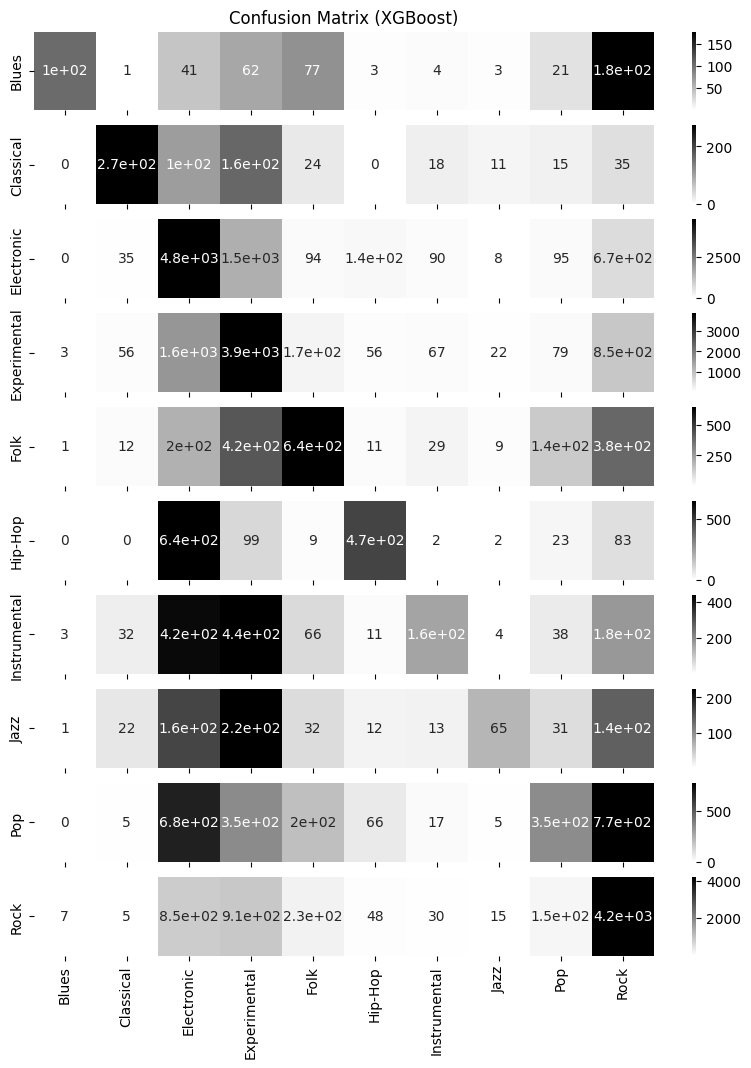

In [71]:
fig, axs = plt.subplots(10, figsize=(10,12), sharex=True)
axs[0].set_title('Confusion Matrix (XGBoost)')
axs[9].set_xlabel('Predicted labels')

for i in range(10):    
    sns.heatmap(confusion_matrix(y_true, y_pred)[i].reshape(1,-1), annot=True, cmap='gray_r',
                xticklabels=cat_y.categories, yticklabels=[cat_y.categories[i]], ax=axs[i])
plt.show()

In [72]:
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred))
print(dict(zip(cat_y.categories, range(10))))

XGB classification report: 

              precision    recall  f1-score   support

           0       0.87      0.21      0.34       492
           1       0.62      0.42      0.50       642
           2       0.51      0.65      0.57      7434
           3       0.48      0.57      0.52      6777
           4       0.42      0.35      0.38      1838
           5       0.58      0.35      0.44      1336
           6       0.37      0.12      0.18      1351
           7       0.45      0.09      0.15       701
           8       0.37      0.14      0.21      2441
           9       0.56      0.65      0.60      6425

    accuracy                           0.51     29437
   macro avg       0.52      0.36      0.39     29437
weighted avg       0.50      0.51      0.48     29437

{'Blues': 0, 'Classical': 1, 'Electronic': 2, 'Experimental': 3, 'Folk': 4, 'Hip-Hop': 5, 'Instrumental': 6, 'Jazz': 7, 'Pop': 8, 'Rock': 9}


Most misclassified genre pairs

- Predicted Rock for Blues

- Predicted Electronic for Hip Hop

- Predicted Electronic for Instrumental

- Predicted Experimental for Instrumental

- Predicted Experimental for Jazz

- Predicted Electronic for Pop

- Predicted Rock for Pop

Interpretation

1. The labels consist of mostly Electronic, Experimental and Rock. Therefore the model would predict the most common labels.

2. You can see some similarty in genres like rock and blues, electronic and pop or hip hop.

3. Experimental and Instrumental genres are not really musically dinstiguised genres in my opinion.

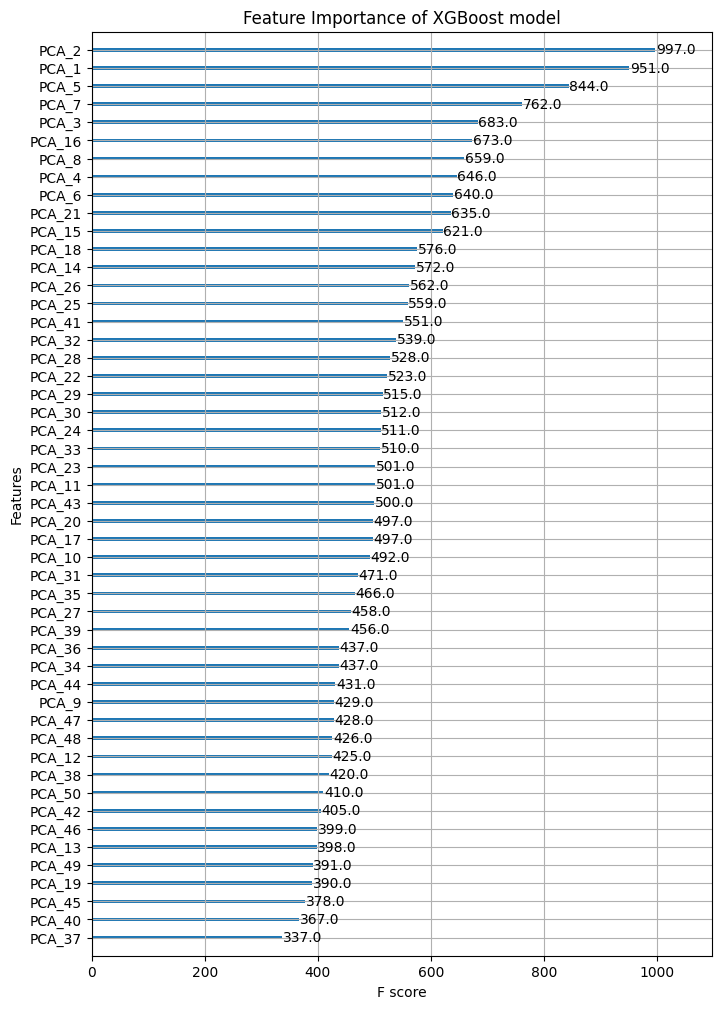

In [73]:
fig, ax = plt.subplots(figsize=(8,12))
from xgboost import plot_importance
plot_importance(xgb, ax=ax, title='Feature Importance of XGBoost model')
plt.show()

PCA2, PCA5, PCA1 have high scores. As you see the PCA factor loadings (showed in heatmap), MFCC features (mean, max, min, median) seem to be important.

And  spectral features contribute the most to PCA7.